In [1]:
# Setups
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import concurrent.futures
from GoogleImageScraper import GoogleImageScraper as gis
import time
from GoogleImageScraper import patch

C:\Users\svolc\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
from GoogleImageScraper import ImageProcessor as ip

In [4]:
patch.webdriver_executable()

'chromedriver.exe'

In [5]:
search_key = "horse"
webdriver_path = os.path.normpath(os.path.join(os.getcwd(), 'webdriver', patch.webdriver_executable()))
a_image_path = os.path.normpath(os.path.join(os.getcwd(), 'photos'))
image_path = os.path.normpath(os.path.join(a_image_path, search_key))

In [12]:
image_scraper = gis.GoogleImageScraper(webdriver_path, search_key, headless=True)

In [14]:
image_scraper.startup()
for x in range(10):
    image_url = image_scraper.next_url()
    print(image_url)

[INFO] Gathering image links


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="islrg"]/div[1]/div[1]/a[1]/div[1]/img"}
  (Session info: chrome=145.0.7632.116); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
Symbols not available. Dumping unresolved backtrace:
	0x7ff65f66aa55
	0x7ff65f3c8630
	0x7ff65f15d75d
	0x7ff65f1b862e
	0x7ff65f1b893c
	0x7ff65f208d87
	0x7ff65f20591c
	0x7ff65f1a9098
	0x7ff65f1a9f83
	0x7ff65f697810
	0x7ff65f691afd
	0x7ff65f6b2c1a
	0x7ff65f3e3345
	0x7ff65f3eb81c
	0x7ff65f3d1924
	0x7ff65f3d1ad6
	0x7ff65f3b7e47
	0x7ffbe5ae7374
	0x7ffbe681cc91


Found 133 image-like URLs
data:image/gif;base64,R0lGODlhAQABAIAAAP///////yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==






























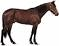
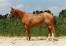
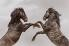
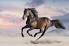
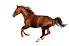
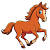
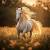
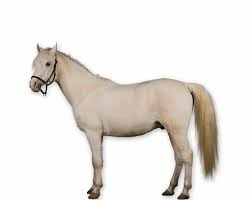
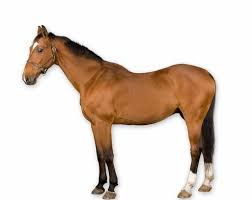
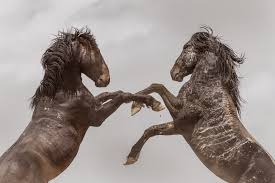
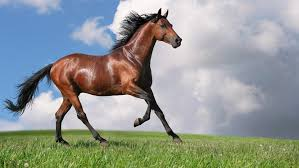
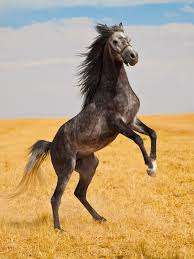
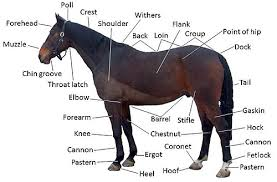
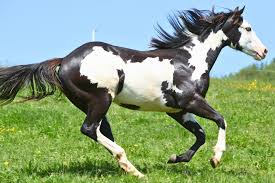
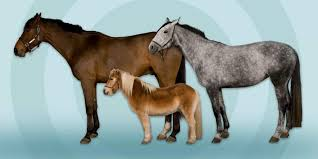
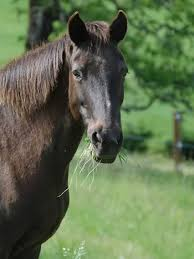
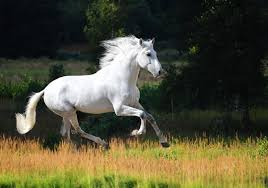
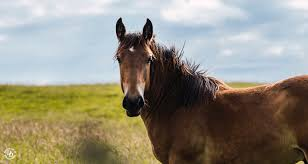
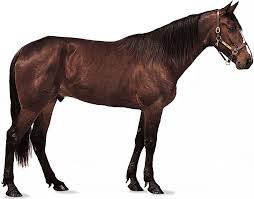
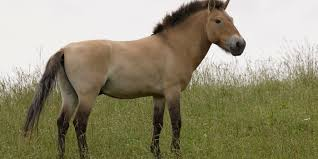
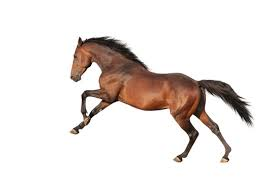
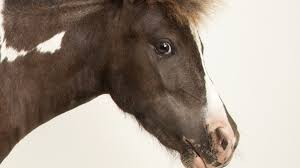
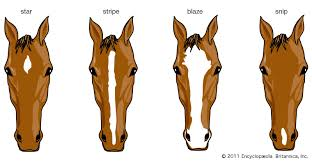
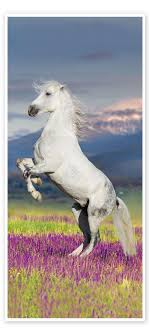

In [17]:
from selenium.webdriver.common.by import By
from urllib.parse import urljoin
import time

def scroll_to_bottom(driver, pause=0.7, max_rounds=20):
    last_h = 0
    for _ in range(max_rounds):
        h = driver.execute_script("return document.body.scrollHeight")
        if h == last_h:
            break
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause)
        last_h = h


import re
from selenium.webdriver.common.by import By
from urllib.parse import urljoin

def parse_srcset(srcset):
    # "url1 1x, url2 2x" or "url 480w, url 800w" -> [url1, url2]
    parts = [p.strip().split(" ")[0] for p in srcset.split(",") if p.strip()]
    return [p for p in parts if p]

def find_image_urls(driver):
    attrs = ["src", "data-src", "data-original", "data-lazy-src", "data-image", "currentSrc"]
    urls = set()

    imgs = driver.find_elements(By.CSS_SELECTOR, "img")
    for img in imgs:
        for a in attrs:
            v = img.get_attribute(a)
            if v:
                urls.add(v)

        srcset = img.get_attribute("srcset")
        if srcset:
            for u in parse_srcset(srcset):
                urls.add(u)

    # normalize relative -> absolute; drop empty and non-http(s) unless you want blob/data
    base = driver.current_url
    norm = set()
    for u in urls:
        u = u.strip()
        if not u:
            continue
        if u.startswith("//"):
            u = "https:" + u
        if u.startswith("/"):
            u = urljoin(base, u)
        norm.add(u)

    return sorted(norm)


from selenium import webdriver
driver = webdriver.Chrome()
url = "https://www.google.com/search?q=%s&source=lnms&tbm=isch&sa=X&ved=2ahUKEwie44_AnqLpAhUhBWMBHUFGD90Q_AUoAXoECBUQAw&biw=1920&bih=947"%(search_key)
driver.get(url)
time.sleep(3)
scroll_to_bottom(driver)
img_urls = find_image_urls(driver)

print("Found", len(img_urls), "image-like URLs")

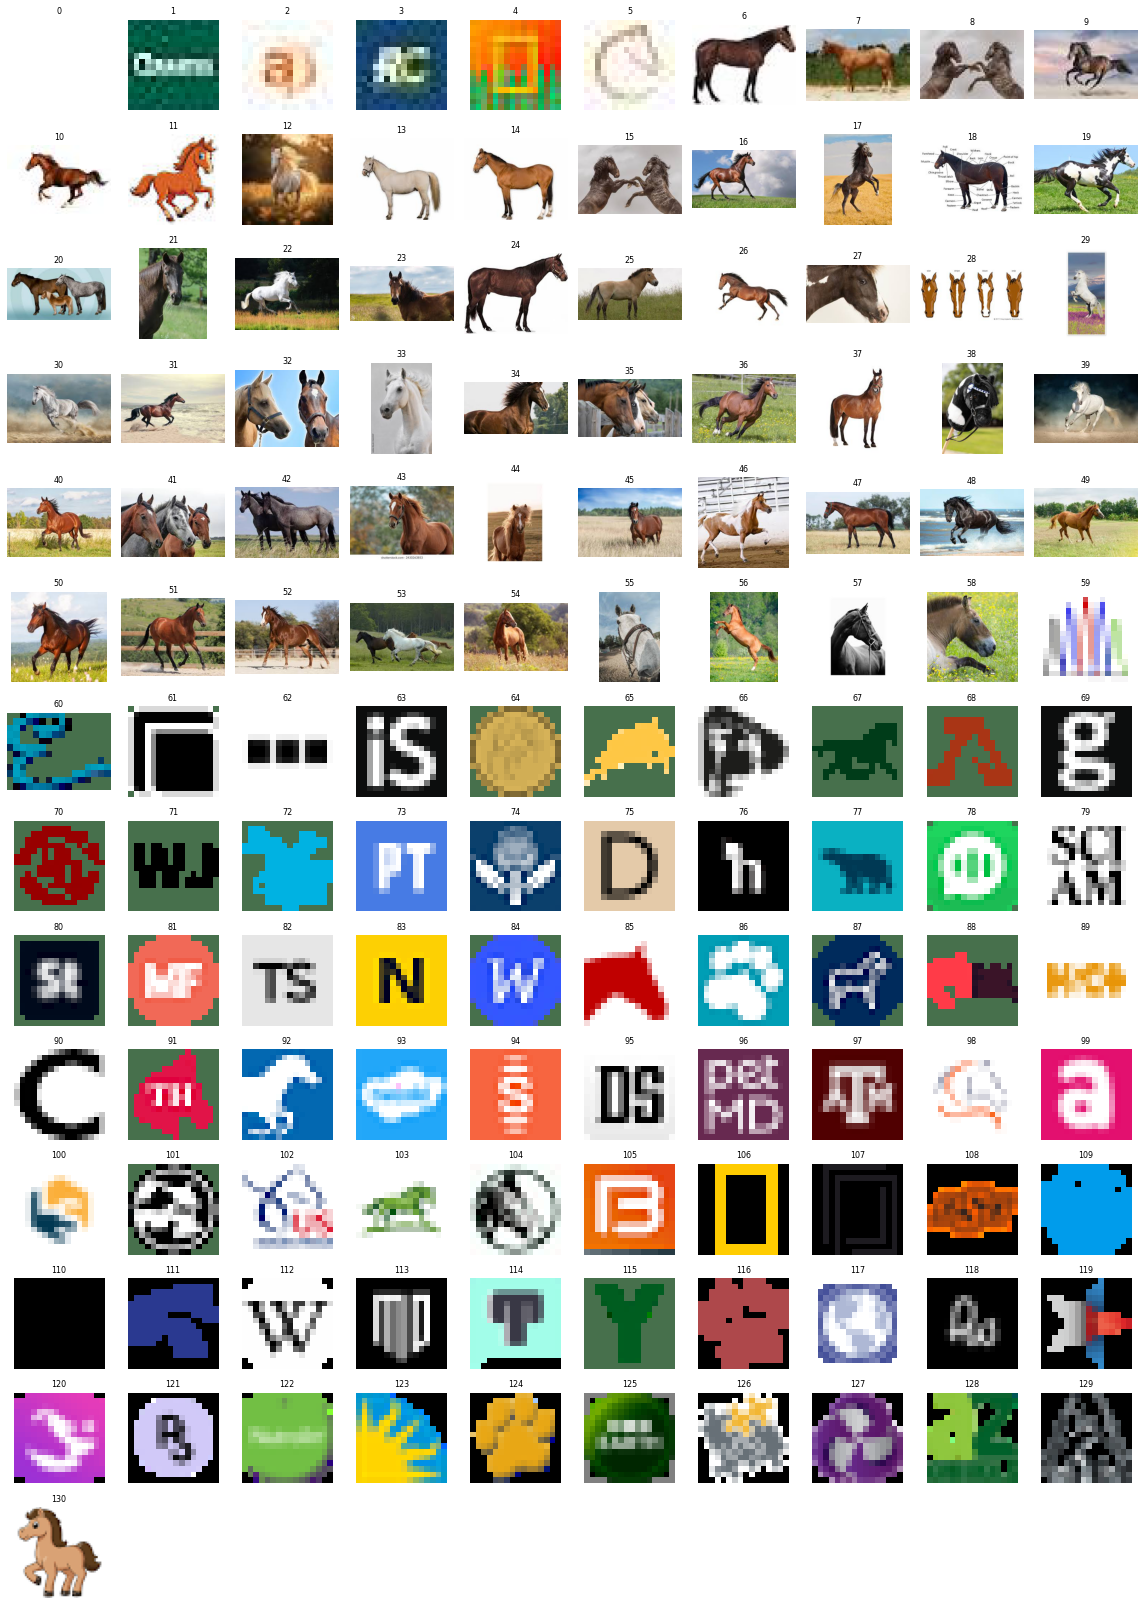

In [33]:
import math
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def decode_data_image(data_url: str) -> Image.Image:
    header, b64 = data_url.split(",", 1)
    img_bytes = base64.b64decode(b64)
    return Image.open(BytesIO(img_bytes)).convert("RGB")

def show_dataurl_grid(img_urls, per_row=10, max_images=None, figsize_per_cell=1.6):
    data_urls = [u for u in img_urls if isinstance(u, str) and u.startswith("data:image/")]
    if max_images is not None:
        data_urls = data_urls[:max_images]

    n = len(data_urls)
    if n == 0:
        print("No data:image/... URLs found in img_urls")
        return

    ncols = per_row
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(ncols * figsize_per_cell, nrows * figsize_per_cell)
    )

    # axes can be 2D or 1D depending on nrows/ncols
    axes = axes.ravel() if hasattr(axes, "ravel") else [axes]

    for ax in axes:
        ax.axis("off")

    for i, data_url in enumerate(data_urls):
        img = decode_data_image(data_url)
        axes[i].imshow(img)
        axes[i].set_title(str(i), fontsize=8)

    plt.tight_layout()
    plt.show()

# Usage:
show_dataurl_grid(img_urls, per_row=10)

In [24]:
len(img_urls)

133

In [34]:
search_key = "airplane"
url = "https://www.google.com/search?q=%s&source=lnms&tbm=isch&sa=X&ved=2ahUKEwie44_AnqLpAhUhBWMBHUFGD90Q_AUoAXoECBUQAw&biw=1920&bih=947"%(search_key)
driver.get(url)
time.sleep(3)
scroll_to_bottom(driver)
img_urls_plane = find_image_urls(driver)

print("Found", len(img_urls_plane), "image-like URLs")

Found 115 image-like URLs


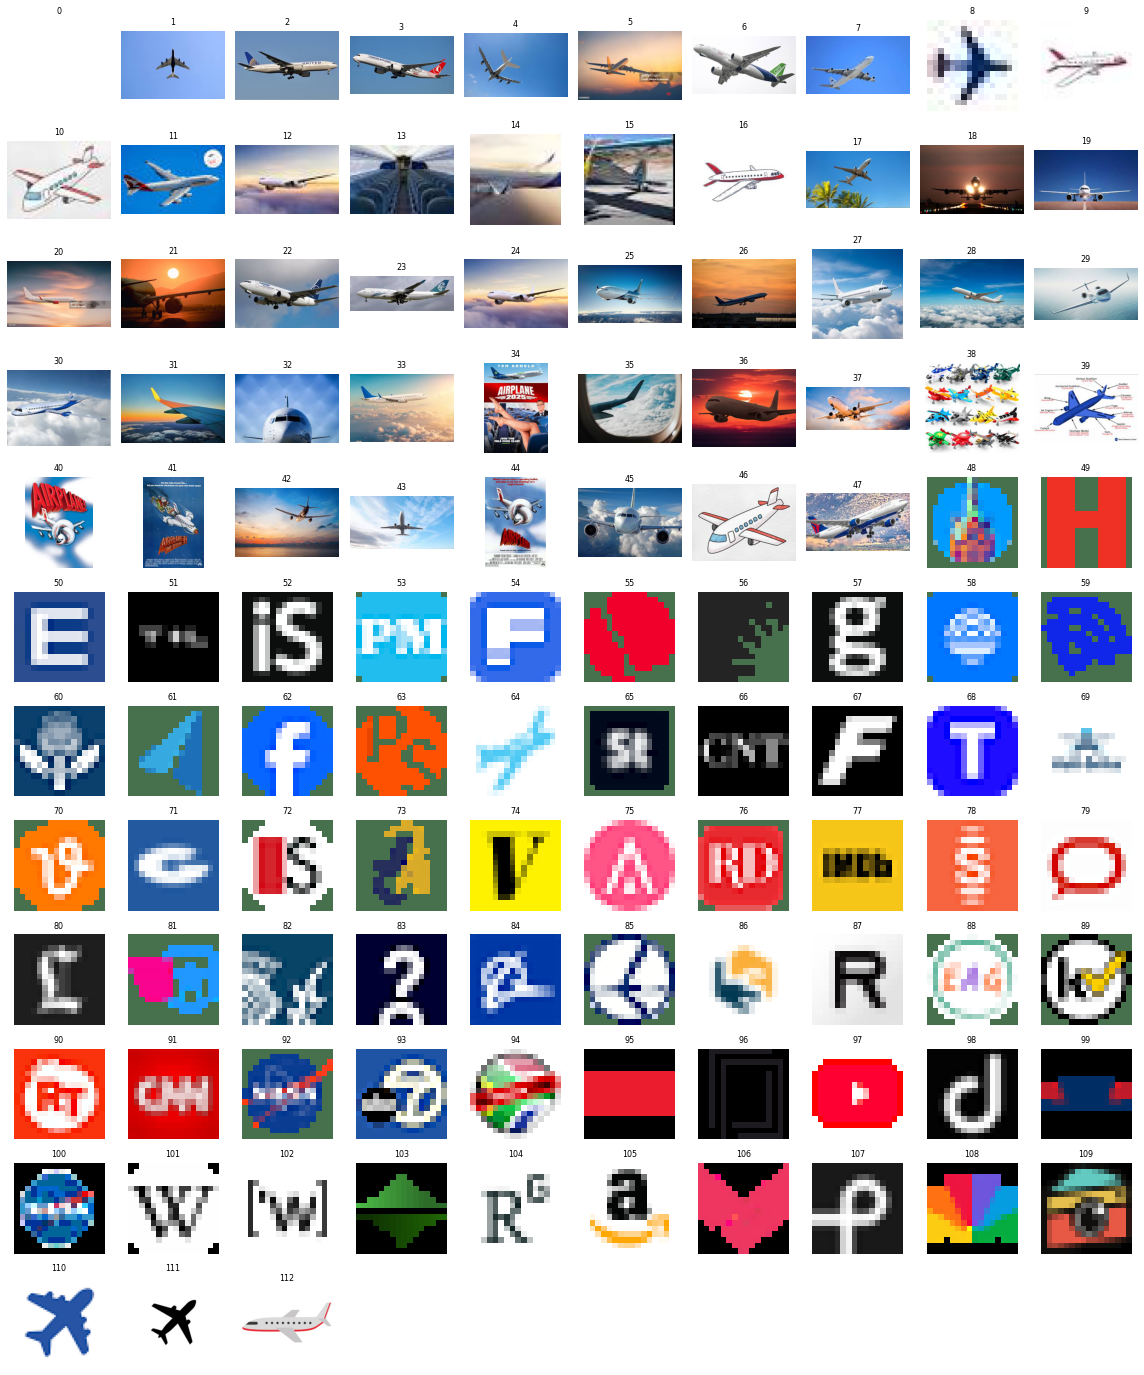

In [35]:
show_dataurl_grid(img_urls_plane, per_row=10)

In [36]:
os.getcwd()

'C:\\Users\\svolc\\OneDrive\\Documents\\repos\\DLLabs\\Lab 2'

MIME: image/png
Size: (16, 16)


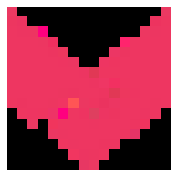

In [40]:
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def decode_data_image(data_url: str):
    """
    data_url: e.g. 'data:image/jpeg;base64,/9j/4AAQ...'
    returns: (PIL.Image, mime_type)
    """
    header, b64 = data_url.split(",", 1)
    # header like: data:image/jpeg;base64
    mime = header.split(";", 1)[0].split(":", 1)[1]  # 'image/jpeg'
    img_bytes = base64.b64decode(b64)
    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    return img, mime

# ---- test on one item you already extracted ----
# img_urls is your list of strings
s = img_urls_plane[106]  # pick any index
img, mime = decode_data_image(s)

print("MIME:", mime)
print("Size:", img.size)

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

In [42]:
from urllib.parse import urlsplit
def describe_img_url(u: str):
    u = (u or "").strip()

    # Case 1: data URL (base64)
    if u.startswith("data:image/"):
        header, b64 = u.split(",", 1)
        mime = header.split(";", 1)[0].split(":", 1)[1]  # e.g. image/jpeg
        img_bytes = base64.b64decode(b64)
        with Image.open(BytesIO(img_bytes)) as im:
            fmt = im.format  # e.g. JPEG/PNG (may be None after convert)
            w, h = im.size
        return {"kind": "data_url", "mime": mime, "format": fmt, "size": (w, h), "bytes": len(img_bytes)}

    # Case 2: normal URL (http/file/etc.) – we can at least show extension
    path = urlsplit(u).path.lower()
    ext = path.rsplit(".", 1)[-1] if "." in path else ""
    return {"kind": "url", "mime": None, "format": ext.upper() if ext else None, "size": None, "bytes": None}

rows = []
for i, u in enumerate(img_urls_plane):
    try:
        d = describe_img_url(u)
        rows.append((i, d["kind"], d["mime"], d["format"], d["size"], d["bytes"]))
    except Exception as e:
        rows.append((i, "error", None, None, None, None))
        print(f"[{i}] ERROR: {type(e).__name__}: {e}")

for i, kind, mime, fmt, size, nbytes in rows:
    print(f"[{i:04d}] kind={kind:7s} mime={mime} format={fmt} size={size} bytes={nbytes}")

[0000] kind=data_url mime=image/gif format=GIF size=(1, 1) bytes=43
[0001] kind=data_url mime=image/jpeg format=JPEG size=(276, 182) bytes=2335
[0002] kind=data_url mime=image/jpeg format=JPEG size=(275, 183) bytes=4809
[0003] kind=data_url mime=image/jpeg format=JPEG size=(299, 168) bytes=6863
[0004] kind=data_url mime=image/jpeg format=JPEG size=(284, 177) bytes=4476
[0005] kind=data_url mime=image/jpeg format=JPEG size=(275, 183) bytes=5394
[0006] kind=data_url mime=image/jpeg format=JPEG size=(299, 168) bytes=6224
[0007] kind=data_url mime=image/jpeg format=JPEG size=(300, 168) bytes=3487
[0008] kind=data_url mime=image/jpeg format=JPEG size=(16, 16) bytes=445
[0009] kind=data_url mime=image/jpeg format=JPEG size=(46, 46) bytes=630
[0010] kind=data_url mime=image/jpeg format=JPEG size=(61, 46) bytes=1024
[0011] kind=data_url mime=image/jpeg format=JPEG size=(69, 46) bytes=1463
[0012] kind=data_url mime=image/jpeg format=JPEG size=(69, 46) bytes=913
[0013] kind=data_url mime=image/j

In [46]:
import base64
from io import BytesIO
from pathlib import Path
from PIL import Image

def save_large_images(subfolder_name, image_urls, root_dir="extracted_pics", min_w=100, min_h=100):
    """
    Saves all data-url encoded images (data:image/...;base64,...) with size > min_w x min_h
    into extracted_pics/<subfolder_name>/.

    Parameters
    ----------
    subfolder_name : str
        Name of subfolder under extracted_pics/
    image_urls : list[str]
        List of encoded images (typically data URLs) such as img_urls/image_urls
    """
    out_dir = Path(root_dir) / str(subfolder_name)
    out_dir.mkdir(parents=True, exist_ok=True)  # creates extracted_pics/<subfolder_name> if needed [web:319]

    saved = []
    skipped = {"not_data_url": 0, "too_small": 0, "decode_error": 0}

    for i, u in enumerate(image_urls):
        if not isinstance(u, str) or not u.startswith("data:image/") or ";base64," not in u:
            skipped["not_data_url"] += 1
            continue

        try:
            header, b64 = u.split(",", 1)
            mime = header.split(";", 1)[0].split(":", 1)[1]  # e.g. image/jpeg
            ext = mime.split("/", 1)[1].lower() if "/" in mime else "img"
            if ext == "jpeg":
                ext = "jpg"

            img_bytes = base64.b64decode(b64)
            im = Image.open(BytesIO(img_bytes))  # open image from bytes [web:303]
            w, h = im.size

            if not (w > min_w and h > min_h):
                skipped["too_small"] += 1
                continue

            fp = out_dir / f"img_{i:05d}_{w}x{h}.{ext}"
            im.save(fp)
            saved.append(fp)

        except Exception:
            skipped["decode_error"] += 1

    print(f"Saved {len(saved)} images to: {out_dir}")
    print("Skipped:", skipped)
    return saved

saved_files = save_large_images("airplane", img_urls_plane, root_dir="C:\\Users\\svolc\\OneDrive\\Documents\\repos\\DLLabs\\Lab 3\\extracted_pics")

Saved 41 images to: C:\Users\svolc\OneDrive\Documents\repos\DLLabs\Lab 2\extracted_pics\airplane
Skipped: {'not_data_url': 2, 'too_small': 72, 'decode_error': 0}


In [43]:
os.getcwd()

'C:\\Users\\svolc\\OneDrive\\Documents\\repos\\DLLabs\\Lab 2'